# ANSI-respecting k-means color palette generator

This script tries to generate a color palette from an image for use with the ANSI spec in terminal emulators. It uses a biased flavor of the k-means algorithm to find the closest pixels in an image that correspond to hard 3-bit colors but still respects the aesthetic of the image's colorspace.

## Install dependencies, declare constants

In [1]:
!1>/dev/null pip install \
jupyter \
matplotlib \
numpy \
pillow \
plotly \

%matplotlib inline


import numpy as np
import os
import plotly.graph_objects as go
import subprocess
from colorsys import hsv_to_rgb, rgb_to_hsv

from IPython import display
from IPython.core.display import HTML
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

ANSI = np.array(
    [ 
        [0,0,0],
        [255,0,0],
        [0,255,0],
        [255,255,0],
        [0,0,255],
        [255,0,255],
        [0,255,255],
        [255,255,255],        
    ]
)

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


## Fetch a potential wallpaper image

In [2]:
# Change me!
img_url="https://www.jpl.nasa.gov/spaceimages/images/largesize/PIA23667_hires.jpg"



!curl --progress-bar {img_url} > wallpaper.jpg
wp_path = f"{os.environ['PWD']}/wallpaper.jpg"

######################################################################### 100.0%


NameError: name 'wp' is not defined

## Load image pixels into numpy array

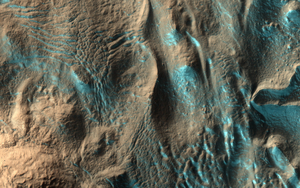

In [3]:
wp=Image.open(wp_path).convert('RGB')
wp.thumbnail((300, 300), resample=Image.LANCZOS)
display.display(wp)

colors=np.array(wp, dtype=int)
colors=colors[:,:,:3]
colors=colors.reshape(colors.shape[0] * colors.shape[1], colors.shape[2])

## Visualize the image's colorspace

In [ ]:
Xs = colors[:,0]
Ys = colors[:,1]
Zs = colors[:,2]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=Xs,
            y=Ys,
            z=Zs,
            mode='markers',
            marker=dict(
                size=3,
                color=colors,
                opacity=1.0
            )
        ),
        go.Scatter3d(
            x=ANSI[:,0],
            y=ANSI[:,1],
            z=ANSI[:,2],
            mode='markers',
            marker=dict(
                size=3,
                color=ANSI,
                opacity=1.0
            )
        )
    ]
)
camera = dict(
    eye=dict(x=1, y=-2, z=1)
)
fig.update_layout(
    width=800, height=400,
    margin=dict(t=30, r=0, l=20, b=10),
    scene_camera=camera
)
fig.show()

## Do k-means iteration on the image's colorspace with heavy bias towards ANSI pure colors

In [ ]:
# http://flothesof.github.io/k-means-numpy.html
closest_pixel_index_per_ANSI = np.argmin(
    (
        (
            ANSI - colors[:, np.newaxis]
        )**2
    ).sum(axis=2)
    , axis=0
)

closest_pixel_to_each_ANSI  = np.array([colors[closest_pixel_index_per_ANSI[k]] for k in range(ANSI.shape[0])])

# Initialize k-means centroids with the nearest pixel in the image
centroids = closest_pixel_to_each_ANSI.copy()


# Do k-means iteration
for i in range(10):
    
    closest_cluster_index_per_pixel = np.argmin(
        (
            (
                colors - centroids[:, np.newaxis]
            )**2
        ).sum(axis=2)
        , axis=0
    )
        
    closest_pixels_to_each_ANSI = np.array(
        [
            colors[closest_cluster_index_per_pixel==k] 
            for k in range(ANSI.shape[0])
        ]
    )

    centroids = np.array(
        [
            m.mean(axis=0) for m in [
                np.concatenate([
                    closest_pixels_to_each_ANSI[nli],
                    closest_pixel_to_each_ANSI[nli][np.newaxis]
                ])
                for nli in range(closest_pixels_to_each_ANSI.shape[0])
            ]
        ]
    )
    
    centroids = (19 * centroids + ANSI)/20

## Create the bright/bold version of the color palette

In [ ]:
hsvs = np.array(list(map(lambda c: rgb_to_hsv(*c), centroids)))
hsvs[:,2]=np.minimum(hsvs[:,2]*1.5, np.repeat(255, hsvs.shape[0]))
brights=np.array(list(map(lambda c: hsv_to_rgb(*c), hsvs))).clip(0,255)

## Behold the generated color palette
It is relatively consistent with the pure colors normally seen in true 3-bit color

black red green yellow blue magenta cyan white

In [ ]:
display.display(wp)
display.display(
    HTML(
        "".join(
            [
                "<span style='background: {0}'> {0} </span>".format(
#                     '#%02x%02x%02x' % tuple(map(int,c))
                    'rgb(%d,%d,%d)' % tuple(map(int,c))
                ) for c in centroids
            ]
        )
    )
)
display.display(
    HTML(
        "".join(
            [
                "<span style='background: {0}'> {0} </span>".format(
                    'rgb(%d,%d,%d)' % tuple(map(int,c))
                ) for c in brights
            ]
        )
    )
)

## Visualize how the k-means clusters segment the original colorspace

In [ ]:
closest=np.argmin(
    (
        (
            colors - centroids[:, np.newaxis]
        )**2
    ).sum(axis=2)
    , axis=0
)
closest_colors=np.array([ centroids[closest[k]] for k in range(colors.shape[0])])
fig2 = go.Figure(
    data=[
        go.Scatter3d(
            x=Xs,
            y=Ys,
            z=Zs,
            mode='markers',
            marker=dict(
                size=3,
                color=closest_colors,
                opacity=1.0
            )
        )
    ]
)
camera = dict(eye=dict(x=1, y=-2, z=1))
fig2.update_layout(
    width=800, height=400,
    margin=dict(t=30, r=0, l=20, b=10),
    scene_camera=camera
)
fig2.show()

## Show which 3-bit color each centroid corresponds to

In [ ]:

closest_colors=np.array([ ANSI[closest[k]] for k in range(colors.shape[0])])
fig3 = go.Figure(
    data=[
        go.Scatter3d(
            x=Xs,
            y=Ys,
            z=Zs,
            mode='markers',
            marker=dict(
                size=3,
                color=closest_colors,
                opacity=1.0
            )
        )
    ]
)
camera = dict(eye=dict(x=1, y=-2, z=1))
fig3.update_layout(
    width=800, height=400,
    margin=dict(t=30, r=0, l=20, b=10),
    scene_camera=camera
)
fig3.show()